# About dataset 
We consider the dataset *Labelled Faces in the Wild (LFW)*, which contains photographies of faces on internet.
Some faces are recognized and have some included photos on the dataset. I consider only people that have at least
70 photos of their faces. Also, I consider the original size of photographies (125×94)

In [74]:
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt
from random import randrange
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns
import pandas as pd
from PIL import Image, ImageOps

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person = 70, resize = 1)

In [3]:
for name in lfw_people.target_names:
    print(name)

Ariel Sharon
Colin Powell
Donald Rumsfeld
George W Bush
Gerhard Schroeder
Hugo Chavez
Tony Blair


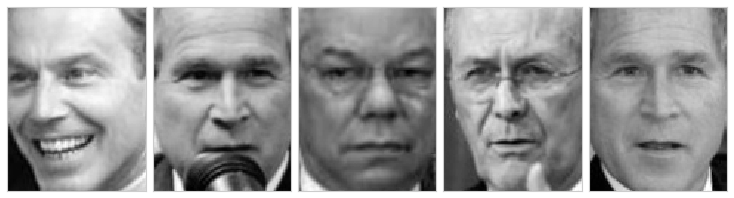

In [4]:
fig = plt.figure(figsize=(10,10)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 
# plot 5 random faces
j = 1
np.random.seed(0)
for i in np.random.choice(range(lfw_people.data.shape[0]), 5): 
    ax = fig.add_subplot(1, 5, j, xticks=[], yticks=[]) 
    ax.imshow(np.reshape(lfw_people.data[i,:],(125,94)), cmap=plt.cm.gray, interpolation='nearest') 
    j += 1
plt.show()

# Splitting dataset and  getting the *eigenfaces* using PCA
**We split the train dataset as 80% of photographies, and remaining 20% for test dataset**

In [5]:
X = lfw_people.data 
y = lfw_people.target
target_names = lfw_people.target_names

In [6]:
X_train, X_test, y_train, y_test, names_train, names_test = train_test_split(X,y,target_names[y],
                                                                            test_size = 0.2, 
                                                                             random_state = 42)

**Decomposing training data by projecting over 2 principal components:**

In [7]:
pca_faces = PCA(2)
faces_proj = pca_faces.fit_transform(X_train)
print('explained variance by two components: ', np.sum(pca_faces.explained_variance_ratio_))
faces_proj[:5]

explained variance by two components:  0.31764066


array([[ 3118.2246 ,   367.82666],
       [-1120.3605 , -1211.3425 ],
       [  490.62717,  -878.0466 ],
       [ -884.66205,  -747.25275],
       [ -785.0593 ,   295.6583 ]], dtype=float32)

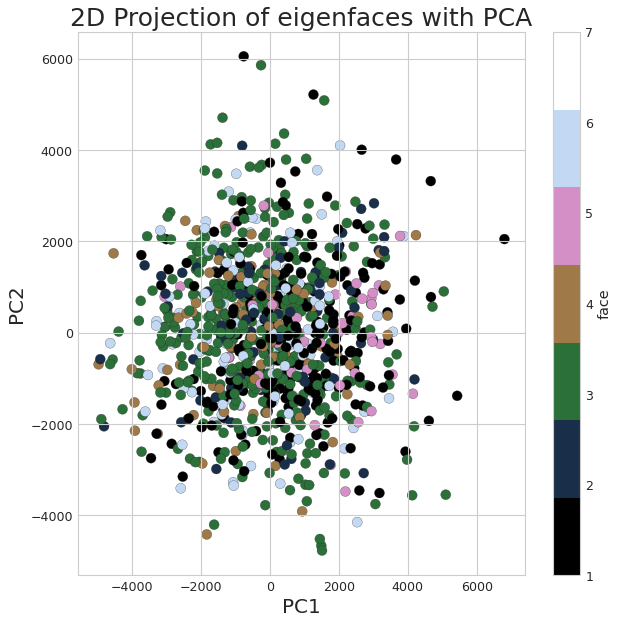

In [8]:
plt.figure(figsize=(10,10))
plt.scatter(faces_proj[:, 0], faces_proj[:, 1], lw=0.25, c=y_train, edgecolor='k',
            s=100, cmap=plt.cm.get_cmap('cubehelix', 7))
plt.xlabel('PC1', size=20), plt.ylabel('PC2', size=20), plt.title('2D Projection of eigenfaces with PCA', size=25)
plt.colorbar(ticks=range(1,8), label='face')
plt.clim(1, 7)

**Computing the eigenfaces:**

In [9]:
eigenfaces = pca_faces.components_.reshape((2, 125, 94))

**Plotting the eigenfaces:**

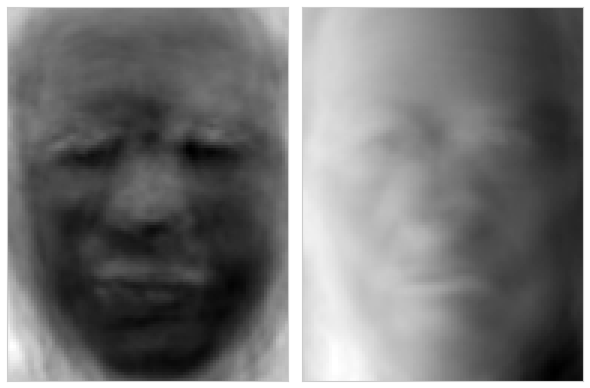

In [10]:
fig = plt.figure(figsize=(8,8)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 
j = 1
np.random.seed(0)
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[]) 
ax.imshow(eigenfaces[0], cmap=plt.cm.gray, interpolation='nearest') 
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[]) 
ax.imshow(eigenfaces[1], cmap=plt.cm.gray, interpolation='nearest') 

plt.show()

# Projecting test images over principal components for image recognition

In [11]:
eig1 = eigenfaces[0].reshape(11750,1)
eig2 = eigenfaces[1].reshape(11750,1)

In [12]:
#projecting test set
proj_test = np.dot(StandardScaler().fit_transform(X_test),pca_faces.components_.T)
proj_test_df = pd.DataFrame(proj_test, columns=['PC1', 'PC2'])
proj_test_df['names'] = names_test
proj_test_df['set'] = 'test'

#projecting training set
proj_train = np.dot(StandardScaler().fit_transform(X_train),pca_faces.components_.T)
proj_train_df = pd.DataFrame(proj_train, columns=['PC1', 'PC2'])
proj_train_df['names'] = names_train
proj_train_df['set'] = 'train'

In [13]:
proj_df = proj_train_df.append(proj_test_df)
proj_df = proj_df.reset_index()
proj_df.iloc[1280:]

,index,PC1,PC2,names,set
1280,250,17.566509,20.327957,Gerhard Schroeder,test
1281,251,-32.823132,-11.091618,George W Bush,test
1282,252,-36.146152,0.414004,Donald Rumsfeld,test
1283,253,-37.507202,-26.744635,Tony Blair,test
1284,254,28.047628,38.056442,George W Bush,test
1285,255,9.791848,-23.663769,Gerhard Schroeder,test
1286,256,70.420807,49.927490,Donald Rumsfeld,test
1287,257,28.089823,3.094081,Colin Powell,test


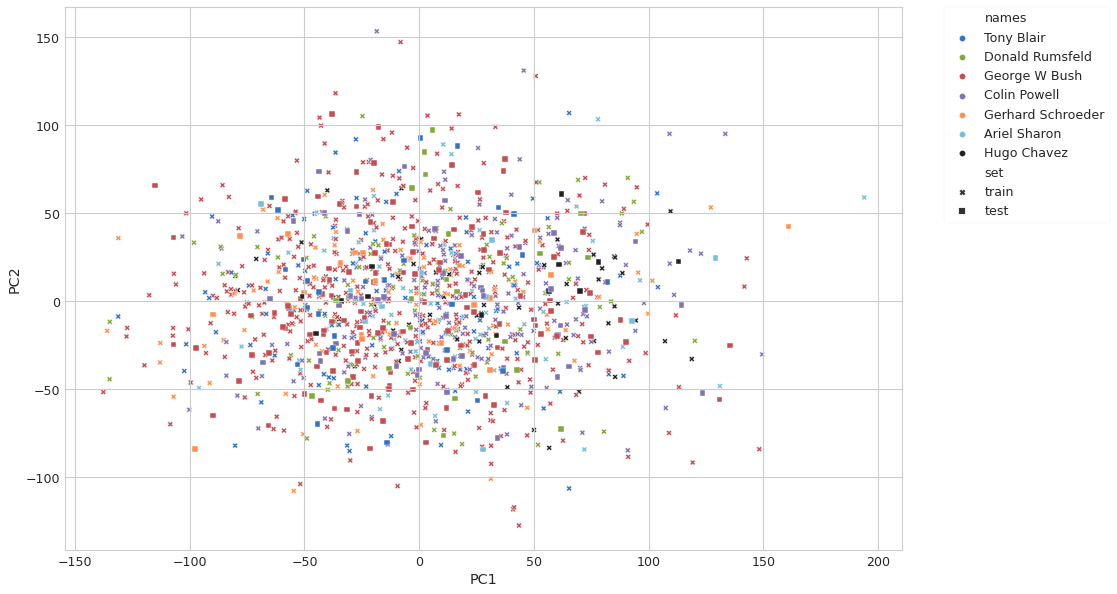

In [14]:
fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(data = proj_df, x = 'PC1', y = 'PC2', hue='names', style='set', markers=['X','s'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


We can see that most of *red faces (George Bush)* in training dataset, makes a good approximation because training data contains many photos of George Bush. It makes easier to the PCA method to recognize images of *test* dataset. As conclusion of this part, as large is the training dataset, it gets a better face recognition. Also, as we will see, the number of principal components plays a big role when approximating *test* dataset.

# Nearest Neighbor algorithm for face recognition:

## Defining an euclidean distance in $\mathbb{R}^p$ space
Here we use the euclidean distance in the space of the first $p$ principal components:

In [15]:
def nearest_neighbor (n_components = 2, test_image = None, train_data=None):
    '''
    
    Returns the nearest image to test image in train dataset using 
    euclidean distance over n_components principal components
    
    
    Parameters
    ----------
    n_components : int, float, None or str
        Number of components to keep.
        if n_components is not set, it will be 2 by default.
        
    test_image: numpy.array
        numpy.array that contains the data entries of test image by joining its rows
        
    train_data: numpy.ndarray
        2 dimensional numpy.ndarray that conntains
        the data entries of every train image by joining its rows
    '''
    nearest_neighbor_pca = PCA(n_components)
    projection = nearest_neighbor_pca.fit_transform(train_data)

    #standarizing faces:
    scaler = StandardScaler()
    train_data_sd = scaler.fit_transform(train_data)
    test_image_sd = (test_image-np.mean(test_image))/np.std(test_image)

    #projecting train Set
    projection_train = np.dot(nearest_neighbor_pca.components_,train_data_sd.T)

    #projecting test image
    projection_test = np.dot(nearest_neighbor_pca.components_, test_image_sd.T)

    #calculating the distance of test image and train images
    diff = projection_train.T - projection_test

    disimilarity = np.dot(diff,diff.T)
    distance = np.diag(disimilarity)**(0.5)
    #getting the index of closest image
    nearest_neighbor_ix = np.argmin(distance)

    #recovering images:
    test_image_ = test_image.reshape(125,94)
    nearest_neighbor_image = train_data[nearest_neighbor_ix].reshape(125,94)

    #plotting test and its nearest neighbor:
    fig = plt.figure(figsize=(8,8)) 
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 

    ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[]) 
    ax.imshow(test_image_, cmap=plt.cm.gray) 
    ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[]) 
    ax.imshow(nearest_neighbor_image, cmap=plt.cm.gray) 
    plt.show()

    return train_data[nearest_neighbor_ix]

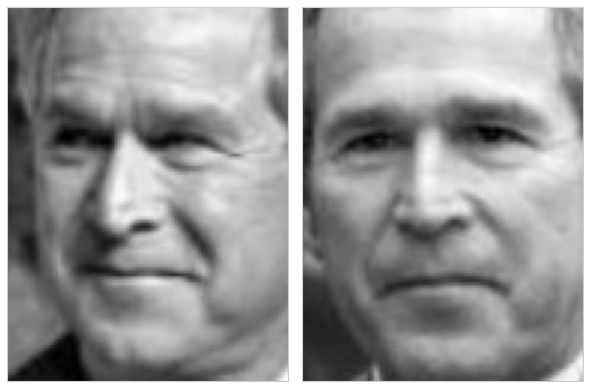

array([ 73.666664,  91.666664,  91.333336, ..., 222.66667 , 207.      ,
       176.33333 ], dtype=float32)

In [72]:
n = randrange(258)
nearest_neighbor(n_components = 100, test_image = X_test[n], train_data = X_train)

We conclude that taking a large number of principal components implies more precision for face recognition. Obviously more time is needed when using more components.

# Taking an image out of dataset:
To see how approximation is when an external object is tested, I insert a picture of me and see what person is my neighbor:

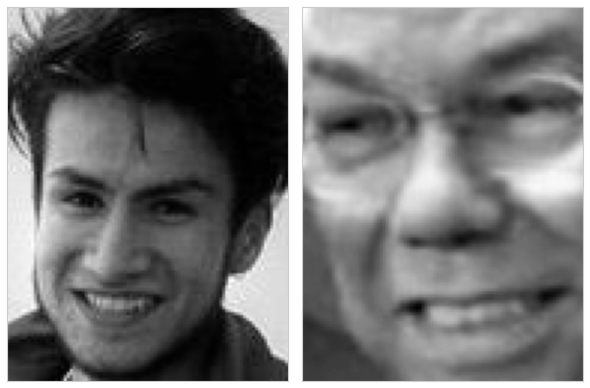

array([244.      , 240.66667 , 230.      , ...,  84.      ,  81.666664,
        82.666664], dtype=float32)

In [106]:
og_image = Image.open("me.jpg")
img_me = ImageOps.grayscale(og_image)
me_test = np.array(img2.getdata())


nearest_neighbor(n_components = 10, test_image = me_test, train_data = X_train)

To prevent things like ones above happen, we can define a maximum distance between train objects.

# Computing principal components with data's transpose

In [108]:
faces_proj_t = pca_faces.fit_transform(X_train.T) #PCA for transpose of train data

Eigenfaces:


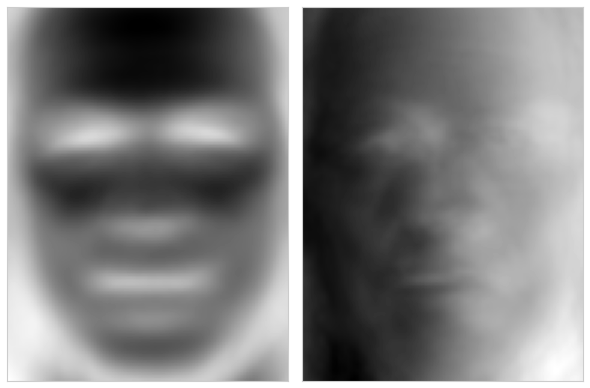

In [121]:
#plotting test and its nearest neighbor:
fig = plt.figure(figsize=(8,8)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 

ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[]) 
ax.imshow(faces_proj_t[:,0].reshape(125,94), cmap=plt.cm.gray) 
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[]) 
ax.imshow(faces_proj_t[:,1].reshape(125,94), cmap=plt.cm.gray) 
print('Eigenfaces:')
plt.show()

We remark that the eigenfaces are the same as computing $X_{train}^{t}X_{train} = S_{11750\times 11750}$, indeed, it's easier to compute
$X_{train}X_{train}^{t} = K_{1030\times 1030}$ because of high dimensionality of data (11750 dimensions!!!). The PCA method works better with $K$ than $S$.